# Detecting hatred speech in tweets

___

The aim of this personal project is to practice what I have learned during the *Machine Learning Fundamentals* classroom course by [Telecom academy](https://www.telacad.ro/cursuri/machine-learning-fundamentals/).

The objective of the task is to detect hate speech in tweets. The dataset was downloaded from [Kaggle](https://www.kaggle.com/arkhoshghalb/twitter-sentiment-analysis-hatred-speech) and consists of a *train* and a *test* file. *train* contains around 30000 labeled tweets. Each row in this dataset has 3 columns:

* *id*: ID assigned to the tweet by Analytics Vidhya (the original dataset provider)
* *label*: tweet label, 1 if tweet has hatred content and 0 otherwise
* *tweet*: tweet text

From the *test* dataset, *label* is missing, so we will analyze our predictions there only at the very end.


Let's start by importing the *train* data:

In [704]:
import pandas as pd

data = pd.read_csv('train.csv')

### A first look on the data

Now let's visualize how our data is looking like for each label and how tweets are spread among the two classes:

In [325]:
data[data['label'] == 0].head(10)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
5,6,0,[2/2] huge fan fare and big talking before the...
6,7,0,@user camping tomorrow @user @user @user @use...
7,8,0,the next school year is the year for exams.ð...
8,9,0,we won!!! love the land!!! #allin #cavs #champ...
9,10,0,@user @user welcome here ! i'm it's so #gr...


In [78]:
data[data['label'] == 1].head(10)

,id,label,tweet
13,14,1,@user #cnn calls #michigan middle school 'buil...
14,15,1,no comment! in #australia #opkillingbay #se...
17,18,1,retweet if you agree!
23,24,1,@user @user lumpy says i am a . prove it lumpy.
34,35,1,it's unbelievable that in the 21st century we'...
56,57,1,@user lets fight against #love #peace
68,69,1,ð©the white establishment can't have blk fol...
77,78,1,"@user hey, white people: you can call people '..."
82,83,1,how the #altright uses &amp; insecurity to lu...
111,112,1,@user i'm not interested in a #linguistics tha...


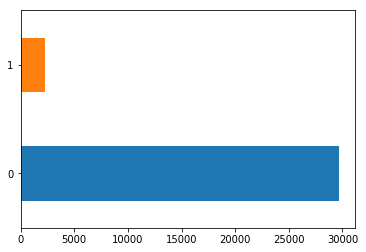

In [3]:
data['label'].value_counts().plot.barh()

We can easily notice that classes are not balanced so considering our task, our aim will be to get a good recall score for hate class.

### Text Preprocessing

In [705]:
tweets = data['tweet'].values
labels = data['label'].values

Fist step: Tokenization. We will choose a tokenizer special created to be used on tweets. Strip handles is set True so '@user' will be removed from our tweets. Also, number of noisy letters will be reduced (example: 'awesomee' will become 'awsome')

In [706]:
from nltk.tokenize import TweetTokenizer

tw_tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True)

tweets_tokens = [tw_tokenizer.tokenize(tweet) for tweet in tweets]

Cleaning the tweets. The function defined it's removing special characters, digits as well as break lines and tabs from text. Lowercase is also being applied and most common abbreviations are replaced.

In [707]:
import re

def clean(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'\n", " ", text)
    text = re.sub(r"\'\t", " ", text)
    text = re.sub('\s+', ' ', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    text = re.sub('\d+', '', text)
    text = re.sub(' +', ' ', text)
    text = text.lower()    
    return text

In [708]:
tweets = [' '.join(tweet) for tweet in tweets_tokens]
tweets = [clean(tweet) for tweet in tweets]

There are a lot of words written together, mostly from hashtags. Those will be splitted using wordninja.

In [709]:
import wordninja

def word_ninja(tweet):
    split_ninja = [wordninja.split(w) for w in tweet]
    tweet_ninja = [sub_word for word_to_split in split_ninja for sub_word in word_to_split]
    return tweet_ninja

tweets_tokens = [tw_tokenizer.tokenize(tweet) for tweet in tweets]
tweets_tokens = [word_ninja(tweet) for tweet in tweets_tokens]

Below it's defined a custom list of stop words. It consists of most NLTK stopwords, but without negative words like 'against', 'don't', 'no', 'not', considering our task. Therefore, stop words from this list will be removed.

In [710]:
stop_words = ["i", "me", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "both", "each", "few", "more", "most", "other", "some", "such", "no", "only", "own", "same", "so", "than", "too", "very", "s", "can", "will", "just", "should", "now"]

def remove_sw(text, stop_words):
    filtered_words = [w for w in text if w not in stop_words]
    return filtered_words

tweets_tokens = [remove_sw(tweet, stop_words) for tweet in tweets_tokens]
tweets = [' '.join(tweet) for tweet in tweets_tokens]

For lemmatization we will use spaCy (it seems to be better than the one from NLTK):

In [711]:
import spacy

nlp = spacy.load('en_core_web_sm')
tweets_tokens = []

for tweet in tweets:
    
    doc = nlp(tweet)
    tweet_tokens = [token.lemma_ for token in doc if token.lemma_ != '-PRON-']
    tweets_tokens.append(tweet_tokens)

Next we will rejoin tokens together into tweets and then visualize the most frequest words in each class.

In [712]:
tweets = [' '.join(tweet) for tweet in tweets_tokens]
tweets

['father dysfunctional selfish drags kid dysfunction run',
 'thanks ly ft credit not use cause not offer wheelchair van pd x d pointed get thank',
 'bih day majesty',
 'model love u take u time ur',
 'fact guide society motivation',
 'huge fan fare big talking leave chaos pay dispute get show go',
 'camp tomorrow danny',
 'next school year year exam not think school exam hate imagine actor life revolution school girl',
 'win love land cav champion cleveland cleveland cavalier',
 'welcome gr',
 'ireland consumer price index mom climb previous may blog silver gold ex',
 'selfish orlando stand orlando pulse shoot orlando shoot big problem selfish break value love',
 'get see daddy today day get feed',
 'cnn call michigan middle school build wall chant t cot',
 'comment australia op kill bay sea shepherd help cove dolphin cove help cove dolphin',
 'ouch junior angry get junior yu gy oem omg',
 'thankful pane r thankful positive',
 're tweet agree',
 'friday smile around via ig user cookie 

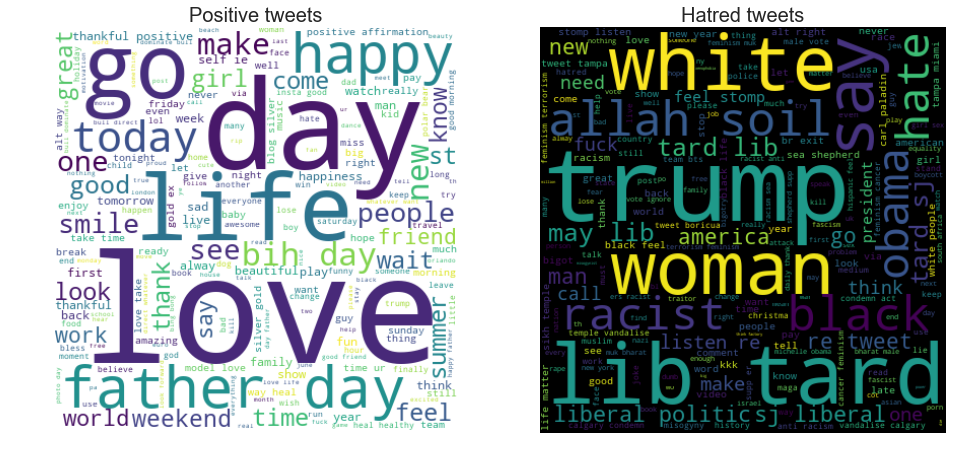

In [713]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

data['tweet'] = tweets

positive_words = ' '.join(data[data.label == 0].tweet.values)
hatred_words = ' '.join(data[data.label == 1].tweet.values)

def generate_WordCloud(pos, neg, title_pos, title_neg):

    plt.figure(figsize=(16, 8))

    cloud1 = WordCloud(width=400, height=400, background_color='white').generate(pos)
    plt.subplot(121)
    plt.imshow(cloud1, interpolation="bilinear")
    plt.axis("off")
    plt.title(title_pos, size=20)

    cloud2 = WordCloud(width=400, height=400, background_color='black').generate(neg)
    plt.subplot(122)
    plt.imshow(cloud2, interpolation="bilinear")
    plt.axis("off")
    plt.title(title_neg, size=20)
    plt.show()
    
generate_WordCloud(positive_words, hatred_words, 'Positive tweets', 'Hatred tweets')

### Train/Test split

In [714]:
import numpy as np

tweets = np.array(tweets)
labels = np.array(labels)

Since we have an inbalanced dataset, we will use stratified shuffle for our Train/Test split.

In [715]:
from sklearn.model_selection import StratifiedShuffleSplit

shuffle_stratified = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 1)

for train_index, test_index in shuffle_stratified.split(tweets, labels):
    tweets_train, tweets_test = tweets[train_index], tweets[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

### Finding best parameters for model and feature extraction

A good solution for finding the best parameters is by using GridSearch. Of course we can extend the pipeline below so that we can find the best combination of vectorizer and model, just that it will take a while for the pipeline to run. Therefore, we assumed that our best picks will be CountVectorizer and MultinomialNB. With the pipeline below we will find best parameters for those.

Source: [scikit-learn documentation](https://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html#sphx-glr-auto-examples-model-selection-grid-search-text-feature-extraction-py)

In [737]:
from pprint import pprint
from time import time
import logging
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('model_nb', MultinomialNB())
])

parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__max_features': (None, 10000, 20000, 50000, 75000, 100000, 150000),
    'vect__ngram_range': ((1, 1), (1, 2), (1,3)),
    'model_nb__alpha': (0.01, 0.1, 1)
}

if __name__ == "__main__":
    grid_search = GridSearchCV(pipeline, parameters, cv=5,
                               verbose=1)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    grid_search.fit(tweets_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'model_nb']
parameters:
{'model_nb__alpha': (0.01, 0.1, 1),
 'vect__max_df': (0.5, 0.75, 1.0),
 'vect__max_features': (None, 10000, 20000, 50000, 75000, 100000, 150000),
 'vect__ngram_range': ((1, 1), (1, 2), (1, 3))}
Fitting 5 folds for each of 189 candidates, totalling 945 fits


[Parallel(n_jobs=1)]: Done 945 out of 945 | elapsed: 27.3min finished


done in 1638.066s

Best score: 0.963
Best parameters set:
	model_nb__alpha: 0.1
	vect__max_df: 0.5
	vect__max_features: None
	vect__ngram_range: (1, 3)


### Training our model

In [733]:
cv = CountVectorizer(ngram_range = (1,2), max_df = 0.5, max_features = 20000)
cv.fit(tweets_train)
X_train = cv.transform(tweets_train)
X_test = cv.transform(tweets_test)

model_nb = MultinomialNB(alpha = 0.1)
model_nb.fit(X_train, y_train)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

### Evaluating our model

10-fold cross validation:

In [734]:
from sklearn.model_selection import cross_val_score, KFold

kf = KFold(10, shuffle=True, random_state = 1)
accuracies = cross_val_score(estimator = model_nb, X = X_train, y = y_train, cv = kf)
accuracies.std()

0.003440007316040934

Standard deviation is low, so we do not have big differences between the scores of our 10-folds.

Classification report:

In [735]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support

y_pred = model_nb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
cm_nb = confusion_matrix(y_test, y_pred)
clf_rep = precision_recall_fscore_support(y_test, y_pred)

def get_classification_report(clf_rep):
    out_dict = {
                 "precision" :clf_rep[0].round(2)
                ,"recall" : clf_rep[1].round(2)
                ,"f1-score" : clf_rep[2].round(2)
                ,"support" : clf_rep[3]
                }

    clf_rep_df = pd.DataFrame(out_dict, index = [0,1])
    print(clf_rep_df)
    
get_classification_report(clf_rep)

   f1-score  precision  recall  support
0      0.98       0.98    0.97     5945
1      0.71       0.67    0.76      448


Plotting the confusion matrix:

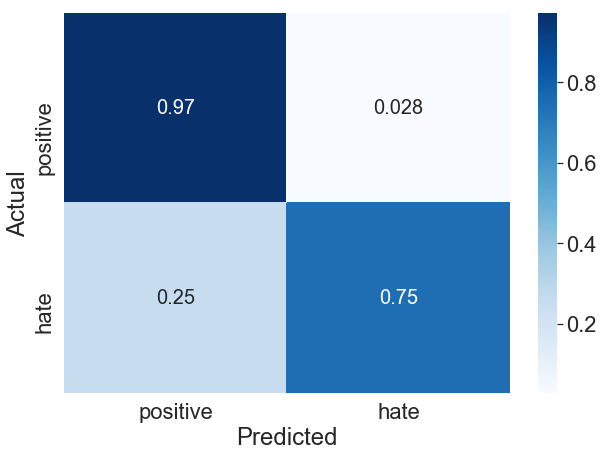

In [567]:
import seaborn as sns 

def plot_confusion_matrix(cm):
    df_cm = pd.DataFrame(cm, columns=['positive', 'hate'], index = ['positive', 'hate'])
    df_cm.iloc[0] = df_cm.iloc[0]/df_cm.iloc[0].sum()
    df_cm.iloc[1] = df_cm.iloc[1]/df_cm.iloc[1].sum()
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize = (10,7))
    sns.set(font_scale=2)
    sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 20})

plot_confusion_matrix(cm_nb)

### Most predictive words

In order to get most predictive features(unigrams or bigrams) for each class we will use *feature_log_prob_* attribute of *MultinomialNB* class. The result will consist of two arrays, one for each class, containing log probability of features. Probabilities will be sorted descending and features will be identified using the sorted indices of our arrays and countvectorizer's *get_feature_names()* method. 

In [261]:
def most_predictive_n_words(model, vectorizer, n):

    pos_class_prob_sorted = np.argsort(-model.feature_log_prob_[0,:])
    neg_class_prob_sorted = np.argsort(-model.feature_log_prob_[1,:])

    most_predictive_pos = np.take(vectorizer.get_feature_names(), pos_class_prob_sorted[:n])
    most_predictive_neg = np.take(vectorizer.get_feature_names(), neg_class_prob_sorted[:n])
    
    return most_predictive_pos, most_predictive_neg

array(['not', 'trump', 'white', 'lib', 'black', 'tard', 'woman', 'like',
       'lib tard', 'new', 'obama', 'people', 'racist', 'allah', 'non',
       'racism', 'hate', 'right', 'liberal', 'man'], dtype='<U29')

In [262]:
print("Most predictive 20, positive class: ", most_predictive_n_words(model_nb, cv, 20)[0])
print("Most predictive 20, negative class: ", most_predictive_n_words(model_nb, cv, 20)[1])

Most predictive 20, positive class:  ['day' 'love' 'not' 'good' 'happy' 'get' 'life' 'go' 'time' 'father'
 'like' 'make' 'new' 'father day' 'today' 'bih' 'bih day' 'see' 'smile'
 'positive']
Most predictive 20, negative class:  ['not' 'trump' 'white' 'lib' 'black' 'tard' 'woman' 'like' 'lib tard'
 'new' 'obama' 'people' 'racist' 'allah' 'non' 'racism' 'hate' 'right'
 'liberal' 'man']


Wordcloud of most predictive words for each class:

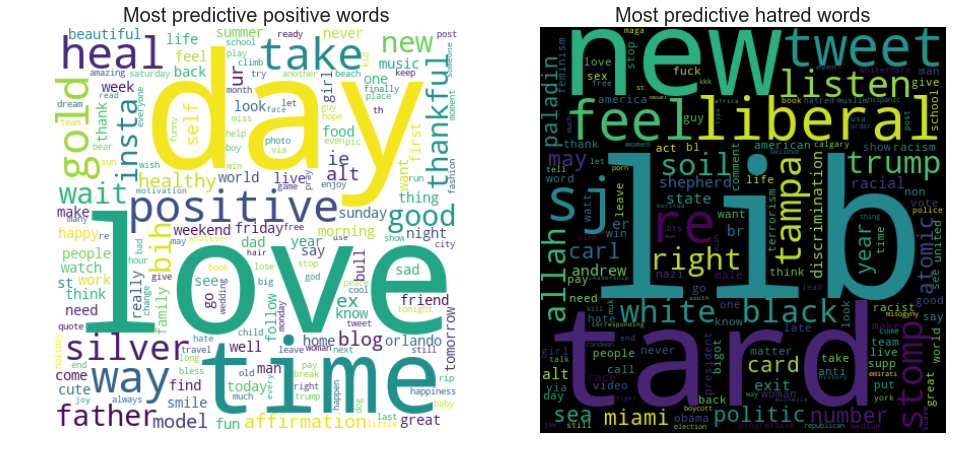

In [264]:
positive = ' '.join(most_predictive_n_words(model_nb, cv, 200)[0])
hatred = ' '.join(most_predictive_n_words(model_nb, cv, 200)[1])

generate_WordCloud(positive, hatred, 'Most predictive positive words', 'Most predictive hatred words')

### Augmenting training hate data

Since our dataset is very inbalanced, we will try to create more hate tweets hoping for better results.

The tweets we want to augment are tweets with label 1 from training set. In order to identify these tweets we will intersect the list of train indexes *train_index* with the one of tweets with label 1:

In [209]:
hate_tweets_index = data[data['label'] == 1].index.values

In [210]:
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2))

to_augment_index = intersection(train_index, hate_tweets_index)

In [380]:
tweets_to_augment = data.iloc[to_augment_index]['tweet']

We will create new hate tweets using three techniques: 
* replace words with synonym in a tweet
* delete words in a tweet
* insert synonyms of words in tweet

Source: [Easy data augmentation techniques for boosting performance on text classification tasks](https://github.com/jasonwei20/eda_nlp?source=post_page-----88e393fd610----------------------)

To get synonyms of a given word, we'll use wordnet synset:

In [695]:
from nltk.corpus import wordnet

def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word): 
        for l in syn.lemmas(): 
            synonym = l.name().replace("_", " ").replace("-", " ").lower()
            synonyms.add(synonym) 
    if word in synonyms:
        synonyms.remove(word)
    return list(synonyms)

get_synonyms('bad')

['regretful',
 'sorry',
 'unfit',
 'spoilt',
 'speculative',
 'badness',
 'forged',
 'tough',
 'high risk',
 'unsound',
 'defective',
 'uncollectible',
 'risky',
 'spoiled',
 'badly',
 'big']

Replace *n* random words with a synonym:

In [694]:
import random
random.seed(1)

def synonym_replacement(words, n):
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word not in stop_words]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if len(synonyms) >= 1:
            synonym = random.choice(list(synonyms))
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n: #only replace up to n words
            break
    sentence = ' '.join(new_words)
    new_words = sentence.split(' ')
    return new_words

synonym_replacement(['bad','war', 'against', 'muslims', 'hate'], 3)

['bad', 'warfare', 'against', 'muslim', 'hatred']

Randomly delete words from the sentence with probability *p*:

In [630]:
def random_deletion(words, p):

    #obviously, if there's only one word, don't delete it
    if len(words) == 1:
        return words

    #randomly delete words with probability p
    new_words = []
    for word in words:
        r = random.uniform(0, 1)
        if r > p:
            new_words.append(word)

    #if you end up deleting all words, just return a random word
    if len(new_words) == 0:
        rand_int = random.randint(0, len(words)-1)
        return [words[rand_int]]

    return new_words

random_deletion(['bad','war', 'against', 'muslims', 'hate'],0.2)

['war', 'against', 'muslims', 'hate']

Insert *n* random words in a sentence. The words inserted will be synonyms of already existing words.

In [631]:
def add_word(new_words):
    synonyms = []
    counter = 0
    while len(synonyms) < 1:
        random_word = new_words[random.randint(0, len(new_words)-1)]
        synonyms = get_synonyms(random_word)
        counter += 1
        if counter >= 10:
            return
    random_synonym = synonyms[0]
    random_idx = random.randint(0, len(new_words)-1)
    new_words.insert(random_idx, random_synonym)

def random_insertion(words, n):
    new_words = words.copy()
    for _ in range(n):
        add_word(new_words)
    return new_words
    
random_insertion(['bad','war', 'against', 'muslims', 'hate'],2)

['bad', 'war', 'against', 'detest', 'moslem', 'muslims', 'hate']

Using the functions defined to add more tweets to our training data:

In [652]:
tweets_to_augment_tokens = [tw_tokenizer.tokenize(tweet) for tweet in tweets_to_augment]
tweets_to_augment_tokens = [x for x in tweets_to_augment_tokens if x != []]

new_hate_tweets_1 = [synonym_replacement(tweet,3) for tweet in tweets_to_augment_tokens]
new_hate_tweets_2 = [random_insertion(tweet,2) for tweet in tweets_to_augment_tokens]
new_hate_tweets_3 = [random_deletion(tweet,0.3) for tweet in tweets_to_augment_tokens]

new_hate_tweets = new_hate_tweets_1 + new_hate_tweets_2 + new_hate_tweets_3

In [447]:
new_hate_tweets

[['put',
  'handsome',
  'girl',
  'pantie',
  'phosphorus',
  'andy',
  'roll',
  'in',
  'the',
  'hay'],
 ['comment',
  'australia',
  'op',
  'stamp',
  'out',
  'bay',
  'ocean',
  'sheepman',
  'help',
  'cove',
  'dolphin',
  'cove',
  'help',
  'cove',
  'dolphin'],
 ['u.s.a.',
  'non',
  'racist',
  'embarrassment',
  'reason',
  'someone',
  'non',
  'like',
  'obama',
  'ignorant',
  'many',
  'f',
  'hio'],
 ['racial',
  'discrimination',
  'manmade',
  'tool',
  'enounce',
  'different',
  'really',
  'not',
  'par'],
 ['ray', 'pinch', 'concur'],
 ['chunky', 'order', 'establish', 'chunky'],
 ['michelle',
  'obama',
  'ape',
  'dog',
  'example',
  'begin',
  'donald',
  'trump',
  'u.s.'],
 ['ag',
  'pick',
  'jeff',
  'seance',
  'scrubs',
  'racism',
  'record',
  'fifty',
  'fifty',
  'tho',
  'fence',
  'felony',
  'trump',
  'america'],
 ['get',
  'to',
  'mitt',
  'livelihood',
  'pretty',
  'darn',
  'cool',
  'case',
  'blatant'],
 ['unbelievable',
  'st',
  '100',

In [653]:
new_hate_tweets = [' '.join(tweet) for tweet in new_hate_tweets]
np.array(new_hate_tweets).shape

(5373,)

New training data:

In [654]:
new_tweets_train = list(tweets_train) + new_hate_tweets
new_y_train = list(y_train) + [1 for x in range(5373)]

Most frequest hate words from our new training set:

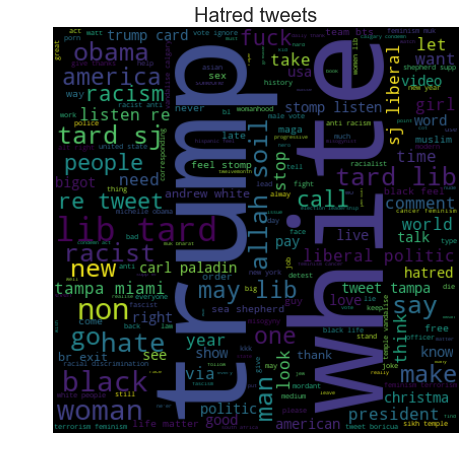

In [655]:
from wordcloud import WordCloud

new_hate_tweets = [tw_tokenizer.tokenize(tweet) for tweet in new_hate_tweets]
stop_words_ = ['atomic', 'number', 'uranium']
new_hate_tweets = [remove_sw(tweet, stop_words_) for tweet in new_hate_tweets]
new_hate_tweets = [' '.join(tweet) for tweet in new_hate_tweets]

hatred_words = ' '.join(new_hate_tweets)

plt.figure(figsize=(16, 8))

cloud2 = WordCloud(width=400, height=400, background_color='black').generate(hatred_words)
plt.subplot(122)
plt.imshow(cloud2, interpolation="bilinear")
plt.axis("off")
plt.title('Hatred tweets', size=20)
plt.show()

### Training and evaluating on new data

Defining the new training dataset:

In [656]:
new_tweets_train = [clean(tweet) for tweet in new_tweets_train]

In [657]:
new_tweets_train = np.array(new_tweets_train)
new_y_train = np.array(new_y_train)

Training:

In [658]:
cv.fit(new_tweets_train)
X_train = cv.transform(new_tweets_train)
X_test = cv.transform(tweets_test)

model_nb.fit(X_train, new_y_train)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

Results:

In [659]:
y_pred = model_nb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
cm_nb = confusion_matrix(y_test, y_pred)
clf_rep = precision_recall_fscore_support(y_test, y_pred)
    
get_classification_report(clf_rep)

   f1-score  precision  recall  support
0      0.98       0.98    0.97     5945
1      0.71       0.66    0.76      448


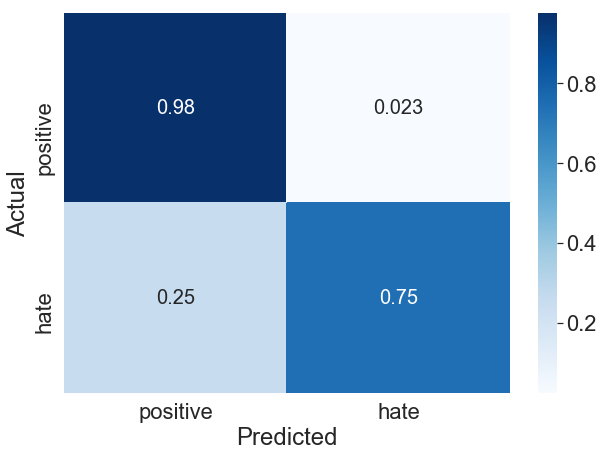

In [277]:
plot_confusion_matrix(cm_nb)

Considering our task, our aim was to get a better recall for hate class.

Most predictive words of our model using new data:

In [660]:
print("Most predictive 20, positive class: ", most_predictive_n_words(model_nb, cv, 20)[0])
print("Most predictive 20, negative class: ", most_predictive_n_words(model_nb, cv, 20)[1])

Most predictive 20, positive class:  ['day' 'love' 'not' 'good' 'happy' 'get' 'life' 'go' 'time' 'father'
 'like' 'make' 'new' 'father day' 'today' 'bih' 'bih day' 'see' 'smile'
 'positive']
Most predictive 20, negative class:  ['not' 'trump' 'white' 'black' 'lib' 'tard' 'lib tard' 'woman' 'like'
 'obama' 'racist' 'new' 'people' 'allah' 'right' 'man' 'racism' 'hate'
 'politic' 'soil']


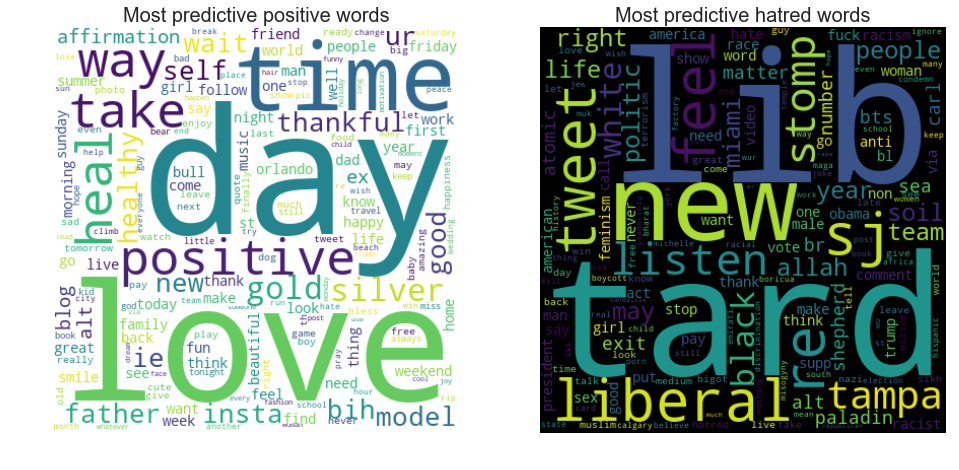

In [661]:
positive = ' '.join(most_predictive_n_words(model_nb, cv, 200)[0])
hatred = ' '.join(most_predictive_n_words(model_nb, cv, 200)[1])

generate_WordCloud(positive, hatred, 'Most predictive positive words', 'Most predictive hatred words')

### Making predictions on unlabeled data

In [683]:
test = pd.read_csv('test.csv')
test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


Text preprocessing:

In [684]:
tweets = test['tweet'].values

tweets_tokens = [tw_tokenizer.tokenize(tweet) for tweet in tweets]
tweets = [' '.join(tweet) for tweet in tweets_tokens]

tweets = [clean(tweet) for tweet in tweets]

tweets_tokens = [tw_tokenizer.tokenize(tweet) for tweet in tweets]
tweets_tokens = [word_ninja(tweet) for tweet in tweets_tokens]

tweets_tokens = [remove_sw(tweet, stop_words) for tweet in tweets_tokens]
tweets = [' '.join(tweet) for tweet in tweets_tokens]

Making predictions:

In [701]:
X = cv.transform(tweets)

In [686]:
y_pred = model_nb.predict(X)

In [702]:
test['labels'] = y_pred

In [703]:
test[test['labels'] == 1]

,id,tweet,labels
3,31966,is the hp and the cursed child book up for res...,1
5,31968,choose to be :) #momtips,1
6,31969,something inside me dies ð¦ð¿â¨ eyes nes...,1
9,31972,#delicious #food #lovelife #capetown mannaep...,1
11,31974,one of the world's greatest spoing events #l...,1
12,31975,half way through the website now and #allgoing...,1
14,31977,i'll stand behind this #guncontrolplease #se...,1
18,31981,"ð­ðð #girls #sun #fave @ london, uni...",1
22,31985,my mind is like ððð½ð but my body l...,1
23,31986,never been this down on myself in my entire li...,1
